In [97]:
# Only Change bag_name

In [185]:
# Imports
import matplotlib.pyplot as plt
import bagpy
import pandas as pd
import numpy as np
import os

In [186]:
def create_folder(path, folder_name):
    # Join the path and folder name
    folder_path = os.path.join(path, folder_name)
    
    # Create the folder if it doesn't exist
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
        print(f"Folder '{folder_name}' created in '{path}'")
    else:
        print(f"Folder '{folder_name}' already exists in '{path}'")

In [227]:
# read rosbag
bag_name = 'my_data_circular3'
path_bag = "/home/mohamed/catkin_ws/src/autonomx_state_estimator/rosbags_encoder/" + bag_name + ".bag"
bag = bagpy.bagreader(path_bag)
# method = 'butterworth_trapezoidal'

[INFO]  Data folder /home/mohamed/catkin_ws/src/autonomx_state_estimator/rosbags_encoder/my_data_circular3 already exists. Not creating.


In [228]:
# extract topics of interest
odom_data = pd.read_csv(bag.message_by_topic('/odom'))
position_data = pd.read_csv(bag.message_by_topic('/vehicle_position'))
velocity_data = pd.read_csv(bag.message_by_topic('/vehicle_velocities'))

#TODO comment
cmd_data = pd.read_csv(bag.message_by_topic('/cmd_vel'))

In [229]:
# Select the Desired columns in odom_data
desired_columns = ['Time', 'pose.pose.position.x', 'pose.pose.position.y', 
                   'twist.twist.linear.x', 'twist.twist.linear.y', 
                   'twist.twist.linear.z', 'twist.twist.angular.z']

# Select only the desired columns
odom_data = odom_data[desired_columns]

# Rename Columns
odom_data = odom_data.rename(columns={
    'twist.twist.linear.z': 'linear_velocity',
    'pose.pose.position.x': 'position_x',
    'pose.pose.position.y': 'position_y',
    'twist.twist.linear.x': 'velocity_x',
    'twist.twist.linear.y': 'velocity_y',
    'twist.twist.angular.z': 'omega_z'
})

position_data = position_data.rename(columns={
    'x' : "encoder_x",
    'y' : "encoder_y",
    'z' : "encoder_theta"

})

velocity_data = velocity_data.rename(columns={
    'x' : "encoder_velocity",
    'y' : "Null",
    'z' : "encoder_omega"

})

#TODO comment
cmd_data = cmd_data.rename(columns={
    'data' : "cmd_vel",
})


In [230]:
# Calculate Time offset
offset_odom = odom_data['Time'].iloc[0]
offset_pos  = position_data['Time'].iloc[0]
offset_vel  = velocity_data['Time'].iloc[0]

offset_cmd = cmd_data['Time'].iloc[0] #TODO comment

# Subtract the offset from all values in the "Time" column
odom_data['Time'] = odom_data['Time'] - offset_odom
position_data['Time'] = position_data['Time'] - offset_pos
velocity_data['Time'] = velocity_data['Time'] - offset_vel

cmd_data['Time'] = cmd_data['Time'] - offset_cmd #TODO comment

print(f"Odom: {offset_odom}\npos : {offset_pos}\nvel : {offset_vel}")

Odom: 1713607515.201951
pos : 1713607515.4086995
vel : 1713607515.4087088


In [231]:
# Calculate Euclidean distance (magnitude) from velocity_x and velocity_y
odom_data['linear_velocity'] = np.sqrt(odom_data['velocity_x']**2 + odom_data['velocity_y']**2)

cmd_data['cmd_vel'] = 33.33*cmd_data['cmd_vel']

In [232]:
odom_data.head()

position_data.head()

velocity_data.head()

cmd_data.head() #TODO comment

,Time,cmd_vel
0,0.000000,0.0
1,0.001709,0.0
2,0.011794,0.0
3,0.021719,0.0
4,0.031932,0.0


In [233]:
## Sort each DataFrame by the "Time" column
# odom_data_sorted = odom_data.sort_values('Time')
# position_data_sorted = position_data.sort_values('Time')
# velocity_data_sorted = velocity_data.sort_values('Time')

# Perform asof merge on the closest timestamps
merged_data = pd.merge_asof(odom_data, position_data, on="Time")
merged_data = pd.merge_asof(merged_data, velocity_data, on="Time")

merged_data = pd.merge_asof(merged_data, cmd_data, on="Time")

# Create a new DataFrame with the desired columns
my_data = pd.DataFrame({
    'Time': merged_data['Time'],
    'position_x': merged_data['position_x'],
    'encoder_x': merged_data['encoder_x'],
    'position_y': merged_data['position_y'],
    'encoder_y': merged_data['encoder_y'],
    'encoder_theta': merged_data['encoder_theta'],
    'linear_velocity': merged_data['linear_velocity'],
    'encoder_velocity': merged_data['encoder_velocity'],
    
    'cmd_velocity' : merged_data['cmd_vel'], #TODO comment

    'omega_z': merged_data['omega_z'],
    'encoder_omega': merged_data['encoder_omega']
})

#reset the index of the new DataFrame
my_data = my_data.reset_index(drop=True)


In [234]:
my_data.head()

my_data.tail()

,Time,position_x,encoder_x,position_y,encoder_y,encoder_theta,linear_velocity,encoder_velocity,cmd_velocity,omega_z,encoder_omega
2367,16.537511,0.218587,-0.008501,1.297070,-0.255705,91.578603,0.00007,0.0,0.0,-0.0,0.0
2368,16.544447,0.218588,-0.008501,1.297070,-0.255705,91.578603,0.00007,0.0,0.0,-0.0,0.0
2369,16.551326,0.218588,-0.008501,1.297069,-0.255705,91.578603,0.00007,0.0,0.0,-0.0,0.0
2370,16.558741,0.218589,-0.008501,1.297069,-0.255705,91.578603,0.00007,0.0,0.0,-0.0,0.0
2371,16.565576,0.218590,-0.008501,1.297069,-0.255705,91.578603,0.00007,0.0,0.0,-0.0,0.0


In [235]:
# set Save path:
folder = bag_name + "/"
plot_save_path = "/home/mohamed/catkin_ws/src/autonomx_state_estimator/Plots/encoder_plots/"
create_folder(plot_save_path, folder)
plot_save_path = plot_save_path + folder

Folder 'my_data_circular3/' already exists in '/home/mohamed/catkin_ws/src/autonomx_state_estimator/Plots/encoder_plots/'


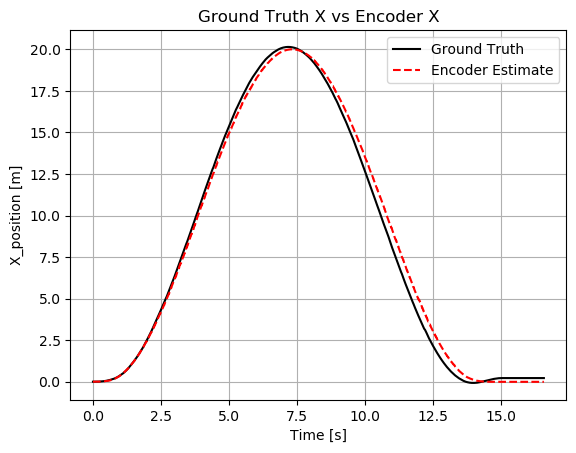

In [236]:
# plt.figure(figsize=(10, 4))  # Width: 8 inches, Height: 6 inches

# Plot position_x and encoder_x against Time
plt.plot(my_data['Time'].values, my_data['position_x'].values,
        'k',
        label='Ground Truth')
plt.plot(my_data['Time'].values, my_data['encoder_x'].values, 
        'r--', 
        label='Encoder Estimate')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('X_position [m]')
plt.title('Ground Truth X vs Encoder X')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Save plot to file
plt.savefig(plot_save_path+"position_X.png")
# Show plot
plt.show()

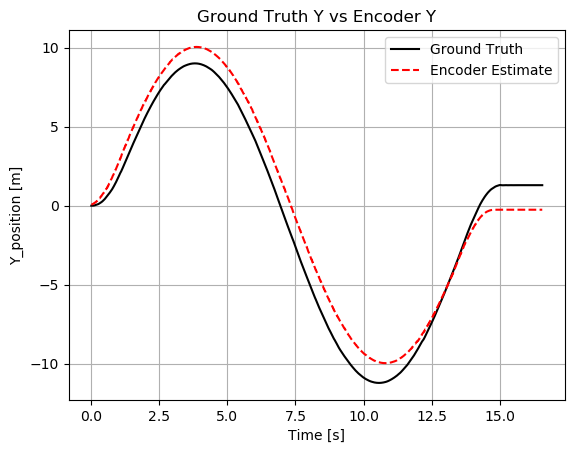

In [237]:
# plt.figure(figsize=(10, 4))  # Width: 8 inches, Height: 6 inches

# Plot position Y
plt.plot(my_data['Time'].values, my_data['position_y'].values,
        'k',
        label='Ground Truth')
plt.plot(my_data['Time'].values, my_data['encoder_y'].values,
        'r--', 
        label='Encoder Estimate')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('Y_position [m]')
plt.title('Ground Truth Y vs Encoder Y')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Save plot to file
plt.savefig(plot_save_path+"position_Y.png")
# Show plot
plt.show()


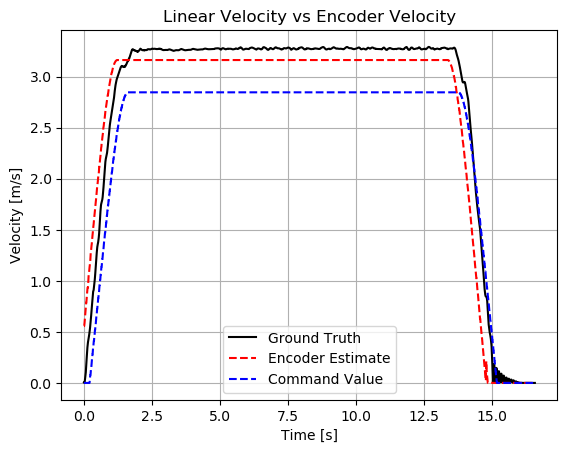

In [238]:
# plt.figure(figsize=(10, 4))  # Width: 8 inches, Height: 6 inches

# Plot both linear velocity and encoder velocity on the same plot
plt.plot(my_data['Time'].values, my_data['linear_velocity'].values, 
         'k',
         label='Ground Truth')
plt.plot(my_data['Time'].values, my_data['encoder_velocity'].values, 
         'r--',
         label='Encoder Estimate')
plt.plot(my_data['Time'].values, my_data['cmd_velocity'].values, 
         'b--',
         label='Command Value')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('Velocity [m/s]')
plt.title('Linear Velocity vs Encoder Velocity')

# Add legend
plt.legend()

# Add grid
plt.grid(True)

# Save plot to file
plt.savefig(plot_save_path+"velocity.png")
# Show plot
plt.show()


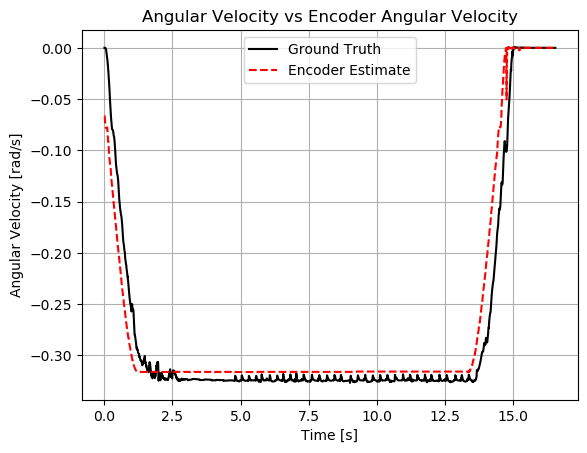

In [239]:
# plt.figure(figsize=(10, 4))  # Width: 8 inches, Height: 6 inches

# Plot both omega_z and encoder_omega on the same plot
plt.plot(my_data['Time'].values, my_data['omega_z'].values,
        'k', 
        label='Ground Truth')
plt.plot(my_data['Time'].values, my_data['encoder_omega'].values, 
        'r--', 
        label='Encoder Estimate')

# Add labels and title
plt.xlabel('Time [s]')
plt.ylabel('Angular Velocity [rad/s]')
plt.title('Angular Velocity vs Encoder Angular Velocity')

# Add legend
plt.legend()

# Add grid
plt.grid(True)


# Save plot to file
plt.savefig(plot_save_path+"omega.png")
# Show plot
plt.show()
